# Coding Challenge - Pedestrian Intentions Prediction

### Imports

In [228]:
import ast
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Pedestrian Crossing Prediction

In this problem I use the opensource JAAD dataset, which you can read more about here: http://data.nvision2.eecs.yorku.ca/JAAD_dataset/ if you are interested.

The dataset consists of tracked people in some videos from a car's dashcam.  Each of these people have been carefully annotated with a bunch of different attributes, such as whether or not they are stopped or moving fast or moving slow.  For this problem I will try to predict whether or not the pedestrian will cross the street in the next frame based on all previous data I have about the pedestrian.  I will use the bounding boxes of the pedestrians along with the other actions that they take to try to predict this for a test set.

## Dataframe

Each row of the dataframe consists of some meta data about the video id and the ped id so that they can match up with the JAAD videos, and then an ordered list of frames where that pedestrian appears.  

* frame_numbers - These should be continuous and there should be no gaps in these lists.  The other fields all align with the frame number field.
* bounding_boxes - This field is a series of boxes that aligns with the frame_numbers field.  Each box is constructed of [box x, box y, box width, box height], where x and y represent the upper left hand corner of the box
* moving_slow, stopped, handwave, look, clear path, moving fast, looking, standing, slow down, nod, speed up - The annotated attributes can be used to train the model, each is a list that aligns with the frame_numbers field of whether or not the attribute is true for that frame number
* crossing - This is the field that I will try to predict, whether or not the pedestrian is crossing for this corresponding frame number 
* cross_overall - Whether or the person crossed at any point in the sequence

In [3]:
pedestrians_df = pd.read_csv('pedestrian_df.csv')
for col_name in ['bounding_boxes', 'frame_numbers', 'moving slow', 'stopped', 'handwave', 'look', 'clear path', 'crossing', 'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']:
    pedestrians_df[col_name] = pedestrians_df[col_name].apply(ast.literal_eval)
pedestrians_df.head()

,video_id,ped_ind,frame_numbers,bounding_boxes,moving slow,stopped,handwave,look,clear path,crossing,moving fast,looking,standing,slow down,nod,speed up,cross_overall
0,video_0071,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[1209, 598, 51, 191], [1214, 598, 52, 192], [...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",False
1,video_0071,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[1249, 621, 51, 127], [1254, 620, 51, 129], [...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True
2,video_0204,1,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[[1135, 673, 28, 97], [1139, 672, 29, 92], [11...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True
3,video_0204,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[906, 670, 35, 65], [906, 672, 32, 65], [907,...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",True
4,video_0204,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[1152, 657, 42, 114], [1158, 657, 42, 117], [...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",False


In [4]:
count = 0
for i, row in pedestrians_df.iterrows():
    count += len(row['frame_numbers'])
    
print("Number of Pedestrian-Frames: %d" % count)

Number of Pedestrian-Frames: 128220


In [5]:
# Let's take a more in-depth look at that first row:
print(pedestrians_df.iloc[0])
print(pedestrians_df.iloc[0]['frame_numbers'])

video_id                                                 video_0071
ped_ind                                                           1
frame_numbers     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
bounding_boxes    [[1209, 598, 51, 191], [1214, 598, 52, 192], [...
moving slow       [False, False, False, False, False, False, Fal...
stopped           [True, True, True, True, True, True, True, Tru...
handwave          [False, False, False, False, False, False, Fal...
look              [False, False, False, False, False, False, Fal...
clear path        [False, False, False, False, False, False, Fal...
crossing          [False, False, False, False, False, False, Fal...
moving fast       [False, False, False, False, False, False, Fal...
looking           [False, False, False, False, False, False, Fal...
standing          [False, False, False, False, False, False, Fal...
slow down         [False, False, False, False, False, False, Fal...
nod               [False, False, False, False, F

# More info

The task I am trying to perform here is to predict, for each pedestrian, whether or not they will be crossing the road at each frame.  For example, for row 0 of the above dataframe, the pedestrian appears in frames 0-329.  For each of those frames, I need to predict whether or not they will be crossing or not crossing in the next frame.  


To solve this problem, I plan on doing the following:
- explore the dataset
- redefine the problem and select an appropriate metric
- unravel the existing per-pedestrian dataframe to build your new per-pedestrian-frame dataframe.  
- extract features
- split the data into train and validation sets (70%-30% split is probably about the right size)
- build a baseline that simply predicts the previous frames' "crossing" value for the next frame
- make some models
- test your final model on your validation set
- write up your analysis

# I/My take on this problem

My take on this problem

This task is a classification problem. We want to classify each image along with the vector of given features (moving_slow, stopped, handwave...) as 'crossing' or 'not crossing'.

## 1 : Processing the data 

One of the key aspects here is that time matters: using images independently from one another would surely result in bad classification accuracy. Thus, I am not sure how a 'per pedestrian frame' dataframe would be of use here.

The first objective is to regroup, for each pedestrian, the corresponding sequences of cropped images and features. However, since we need to keep the order of the images, we cannot simply regroup all the images of each pedestrian together.

What we can do, is regroup images corresponding to the same trajectory, regardless of the pedestrian. This means that we use the pedestrian ID just to constitute a true trajectory, not to regroup all the trajectories together per pedestrian. 
Thus, for each row of the dataframe, we need to constitute a trajectory (sequence of images and corresponding features) that would constitue one sample for the training of our model.

I tried processing images, retrieveing the parts corresponding to the bounding boxes and storing them. The main issue was the following: to feed a convolutional networkthe images need to be all of the same shape, thus they need to be resized, and this operation takes a lot of time. Considering the total number of frames (128220), processing all these frames would have taken hours and a lot of memory. Thus, to avoid this issue, I had to build a dataloader that would create batches of images, crop them according to the bounding boxes and feed them to the networks.

To build this dataloader, several steps were required:

    * retrieve images using the frame indices and the video ID
    
    * crop images according to the bounding boxes, resize them
    
    * convert the feature vector to binary values (0: False, 1: True), retrieve the labels
    
    * create an object, containing the sequence of images and the sequence of feature vectors
    
    * regroup trajectories into training and validation datasets
    
## 2 : Building models

The next step is to build models. When time is involved, two types of neural networks are considered: CNNs and RNNs. Furthermore, since we are processing two types of data at the same time (images and feature vectors), we need to use two networks in parallel and figure out a way to output a prediction based on the outputs of these two networks. We need to perform the following tasks:

    * Build a network to process the images
    
    * Build a network to process the feature vectors
    
    * Output the prediction from the output of the two networks
    
    * Train the networks accordingly, see how they perform

For this task, I decided to divide all the existing trajectories into samples of [trajectory_length] timesteps.
Thus, I am feeding my networks with the following data:

    * N batches of samples of the shape (batch_size, trajectory_length, image_size) for the network processing images
    * N batches of samples of the shape (batch_size, trajectory_length, number of features) for the network processing the metadata

# II/ FIRST METHOD : ONLINE IMAGE PROCESSING

In the first place, I realised that since there are over 120000 frames, it would take a lot of time to process all the videos to take all the relevant frames and store them. thus, I decided to implement an online dataloader that would create batch of frames using the given dataframe. 

The dataloader would use the dataframe to select random rows, extract following frames from videos, crop them and feed them to my networks.

In [128]:
# First Step : Process the data to create a working dataset

# This dataloader creates batch of images corresponding to the trajectory of a pedestrian to feed the networks.
# Dataloader is online: images are extracted, cropped then fed to the networks
        
class dataloader():
    def __init__(self, dataframe, image_repository, image_size, prediction_length):
        self.dataframe = dataframe
        self.image_repository = image_repository
        self.image_size = image_size
        self.prediction_length = prediction_length
        
    def generate_data(self):
        """
        This function generates one training sample : a group of trajectory_length images, 
        and the associated feature vector
        """
        num_trajec = len(self.dataframe.index)
        
        # pick a trajectory
        row_index = np.random.choice(self.dataframe.index)
        n_timesteps = len(self.dataframe.loc[row_index]['frame_numbers'])

        # pick a sequence of prediction_lentgh images
        pred_start = prediction_length * np.random.randint(n_timesteps // self.prediction_length)
        pred_end = pred_start + self.prediction_length

        # retrieve images
        video_path = self.image_repository + '/' + self.dataframe.loc[row_index]['video_id'] + '.mp4'
        frame_indices = self.dataframe.loc[row_index]['frame_numbers'][pred_start:pred_end]
        bounding_boxes = self.dataframe.loc[row_index]['bounding_boxes'][pred_start:pred_end]
        image_list = np.zeros((prediction_length, self.image_size[0], self.image_size[1]))
        capture = cv2.VideoCapture(video_path)
        
        # crop images and resize them
        k=0
        for index, bounding_box in zip(frame_indices, bounding_boxes):
            capture.set(1, index)
            _, frame = capture.read()

            x, y, box_width, box_height = bounding_box
            x, y, box_width, box_height = int(x), int(y), int(box_width), int(box_height)
            image = frame[y:y + box_height, x:x + box_width]  # cropping
            img = cv2.resize(image, self.image_size, interpolation = cv2.INTER_NEAREST)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
            image_list[k] = img
            k+=1

        # retrieve features
        features = ['moving slow', 'stopped', 'handwave', 'look', 'clear path', 
                    'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']
        num_features = len(features)
        feature_vector = np.zeros((self.prediction_length, num_features))
        
        k=0
        for feature in features:
            content = np.array(self.dataframe.loc[row_index][feature], dtype = 'int')[pred_start:pred_end]
            feature_vector[:,k] = content
            k+=1

        # retrieve labels
        labels = np.array(self.dataframe.loc[row_index]['crossing'], dtype = 'int')[pred_start:pred_end]
        labels = np.reshape(labels, (-1, 1))

        return (image_list, feature_vector, labels)
    
    
    def generate_feature_vec(self):
        """
        This function generates one training sample for the case where we only use the features as 
        training data and not the images.
        """
        
        # pick a trajectory
        row_index = np.random.choice(self.dataframe.index)
        n_timesteps = len(self.dataframe.loc[row_index]['frame_numbers'])

        # pick a sequence of prediction_lentgh features
        pred_start = prediction_length * np.random.randint(n_timesteps // self.prediction_length)
        pred_end = pred_start + self.prediction_length
        
        # retrieve features
        features = ['moving slow', 'stopped', 'handwave', 'look', 'clear path', 
                    'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']
        num_features = len(features)
        feature_vector = np.zeros((self.prediction_length, num_features))
        
        k=0
        for feature in features:
            content = np.array(self.dataframe.loc[row_index][feature], dtype = 'int')[pred_start:pred_end]
            feature_vector[:,k] = content
            k+=1
        
        # retrieve labels
        labels = np.array(self.dataframe.loc[row_index]['crossing'], dtype = 'int')[pred_start:pred_end]
        labels = np.reshape(labels, (-1, 1))
        
        return feature_vector, labels
    
    
    def training_data(self, batch_size, just_feature_vector = False):
        """
        This function generates a batch of data, using the above functions.
        """
        
        feature_batch = np.zeros((batch_size, self.prediction_length, 11))
        label_batch = np.zeros((batch_size, self.prediction_length, 1))
        
        # If the images are not used
        if just_feature_vector:
            for i in range(batch_size):
                feature_vector, labels = self.generate_feature_vec()
                feature_batch[i] = feature_vector
                label_batch[i] = labels
            return (feature_batch, label_batch)
        
        # If the images are used
        else:
            image_batch = np.zeros((batch_size, self.prediction_length, self.image_size[0], self.image_size[1]))
            for i in range(batch_size):
                image_list, feature_vector, labels = self.generate_data()
    
                image_batch[i] = image_list
                feature_batch[i] = feature_vector
                label_batch[i] = labels

            return (image_batch, feature_batch, label_batch)
        
        

def training_validation_dataframes(dataframe, training_split = 0.7):
    """
    This function splits the main dataframe into two dataframes, one for training and one for validation.
    """
    new_dataframe = dataframe.copy()
    num_trajec = len(new_dataframe.index)
    train_idx = np.random.choice(num_trajec, int(training_split*num_trajec), replace = False)
    training_dataframe = new_dataframe.iloc[train_idx]
    validation_dataframe = new_dataframe.drop(train_idx)
    
    num_training_samples = 0
    for i, row in training_dataframe.iterrows():
        num_training_samples += len(row['frame_numbers'])//4
    num_validation_samples = 0
    for i, row in validation_dataframe.iterrows():
        num_validation_samples += len(row['frame_numbers'])//4
    
    return training_dataframe, validation_dataframe, num_training_samples, num_validation_samples






## 2 Let us now build the models for the classification task

I use the following models:
    
    * A CNN-LSTM for feature extraction from the images and label prediction
    * A LSTM for feature extraction from the feature vector and label prediction

The predictions from the above two networks are added using a third network, and I use BinaryCrossEntropy to compute the loss. Indeed, this problem can be seen as a multilabel classification problem: for a sequence of images and feature vector, I am trying to determine for each image if the pedestrian is crossing or not. Thus, the prediction and label vectors will be of the shape (trajectory_length, 1).

In [234]:
class feature_network(nn.Module):  # This network processes the features from the given dataframe
    
    def __init__(self, input_dim, activation, loss, batch_size, prediction_length = 4):
        super(feature_network, self).__init__()
        self.input_dim = input_dim
        self.activation = activation
        self.loss = loss
        self.batch_size = batch_size
        self.prediction_length = prediction_length
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size = self.input_dim, hidden_size = 12, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = 12, hidden_size = 8, batch_first = True)
        self.lstm3 = nn.LSTM(input_size = 8, hidden_size = self.prediction_length, batch_first = True)
        self.lstm4 = nn.LSTM(input_size = self.prediction_length, hidden_size = 1, batch_first = True)

    def forward(self, x):
        activ = nn.Sigmoid()
        x1, _ = self.lstm1(x)
        x2, _ = self.lstm2(x1)
        x3, _ = self.lstm3(x2)
        x4, _ = self.lstm4(x3)
        
        output = activ(torch.reshape(x4, (self.batch_size, 4, 1)))
        
        return output
    
    def train(self, train_dataloader, valid_dataloader, num_training_samples, loss_function, options):
        """
        This function is to use only if one desires to train this model alone without using the images
        """
        print('Training model...')
        num_iters = num_training_samples // self.batch_size
        #num_iters = 10
        prediction_length = options['prediction_length']
        optimizer = optim.Adam(self.parameters(),
                          lr = options['base_lr'],
                          weight_decay = options['weight_decay'])

        list_train_loss = []
        list_train_accuracy = []
        list_valid_loss = []
        list_valid_accuracy = []
        
        for epoch in range(options['num_epochs']):
            average_train_loss = 0.0
            average_accuracy = 0


            for iteration in range(num_iters):
                feature_batch, label_batch = train_dataloader.training_data(batch_size = self.batch_size, just_feature_vector = True)
                feature_batch = torch.tensor(feature_batch, dtype = torch.float)
                label_batch = torch.tensor(label_batch, dtype = torch.float)

                optimizer.zero_grad()  # starting fresh

                # forward pass
                y_hat = self.forward(feature_batch)
                y = label_batch
                loss = loss_function(y_hat, y)

                # compute running loss this epoch
                average_train_loss += loss.item()

                # compute gradients and step
                loss.backward()
                optimizer.step()

                with torch.no_grad():

                    pred = (y_hat>0.5).float()
                    average_accuracy += (pred == y).float().sum()/(self.batch_size*4)
            
            # Validation
            with torch.no_grad():
                feature_batch, label_batch = valid_dataloader.training_data(batch_size = self.batch_size, just_feature_vector = True)
                feature_batch = torch.tensor(feature_batch, dtype = torch.float)
                label_batch = torch.tensor(label_batch, dtype = torch.float)
                
                # Validation loss
                y_hat = self.forward(feature_batch)
                y = label_batch
                valid_loss = loss_function(y_hat, y)
                
                # Validation accuracy
                pred = (y_hat>0.5).float()
                valid_accuracy = (pred == y).float().sum()/(self.batch_size*prediction_length)
                
            # storing loss and accuracy
            list_train_loss.append(average_train_loss)
            list_train_accuracy.append(average_accuracy)
            list_valid_loss.append(valid_loss)
            list_valid_accuracy.append(valid_accuracy)
            
            # compute average loss this epoch
            average_train_loss /= float(iteration)
            average_accuracy /= float(iteration) 

            # print epoch details
            print('Epoch: %d, Training loss: %3f, Training accuracy: %3f, Validation loss: %3f, Validation accuracy: %3f' % (epoch+1,average_train_loss, average_accuracy*100, valid_loss, valid_accuracy*100))

        print('~~~~~~~~~~~~~~~~TRAINING COMPLETE~~~~~~~~~~~~~~~~~~')
        return list_train_loss, list_train_accuracy, list_valid_loss, list_valid_accuracy
        
    
    
    
class image_network(nn.Module):  # the CNN-LSTM for image processing
    
    def __init__(self, activation, loss, image_size, batch_size, prediction_length = 4):
        super(image_network, self).__init__()
        self.activation = activation
        self.loss = loss
        self.image_size = image_size
        self.batch_size = batch_size
        self.prediction_length = prediction_length
        
        # Convolutional layers, batchnorm, dropout
        self.BN = torch.nn.BatchNorm2d(self.prediction_length)
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 2)
        size = self.image_size[0]
        self.conv1 = nn.Conv2d(in_channels = self.prediction_length, out_channels = self.prediction_length, kernel_size = 5)
        size -= 4
        size /= 2 
        self.conv2 = nn.Conv2d(in_channels = self.prediction_length, out_channels = self.prediction_length, kernel_size = 5)
        size -= 4
        size /= 2 
        self.conv3 = nn.Conv2d(in_channels = self.prediction_length, out_channels = self.prediction_length, kernel_size = 3)
        size -= 2
        size /= 2
        self.conv4 = nn.Conv2d(in_channels = self.prediction_length, out_channels = self.prediction_length, kernel_size = 3)
        size -= 2
        size /= 2
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size = int(size)*int(size), hidden_size = 64, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = 64, hidden_size = 32, batch_first = True)
        self.lstm3 = nn.LSTM(input_size = 32, hidden_size = 16, batch_first = True)
        self.lstm4 = nn.LSTM(input_size = 16, hidden_size = 8, batch_first = True)
        
        # Linear Layers
        self.fc1 = nn.Linear(8, self.prediction_length)
        self.fc2 = nn.Linear(self.prediction_length, 1)
    
    
    def forward(self, x):
        activ = nn.ReLU()
        
        # Convolutional + Maxpooling + Batchnorm + ReLU + Dropout
        x1 = self.conv1(x)
        x1 = self.maxpool(x1)
        x1 = self.BN(x1)
        x1 = activ(x1)
        x1 = self.dropout(x1)
        
        x2 = self.conv2(x1)
        x2 = self.maxpool(x2)
        x2 = self.BN(x2)
        x2 = activ(x2)
        x2 = self.dropout(x2)
        
        x3 = self.conv3(x2)
        x3 = self.maxpool(x3)
        x3 = self.BN(x3)
        x3 = activ(x3)
        x3 = self.dropout(x3)
        
        x4 = self.conv4(x3)
        x4 = self.maxpool(x4)
        x4 = self.BN(x4)
        x4 = activ(x4)
        x4 = self.dropout(x4)
        
        out1 = x4.view((self.batch_size, self.prediction_length, -1))
        
        # LSTM
        y1, _ = self.lstm1(out1)
        y2, _ = self.lstm2(y1)
        y3, _ = self.lstm3(y2)
        y4, _ = self.lstm4(y3)
        
        # Linear
        z1 = self.activation(self.fc1(y4))
        z2 = self.activation(self.fc2(z1))
        
        return z2.view((self.batch_size, self.prediction_length, 1))
    
    
    def train(self, train_dataloader, valid_dataloader, num_training_samples, loss_function, options):
        """
        This function is to use only if one desires to train this model alone without using the metadata
        """
        print('Training model...')
        num_iters = num_training_samples // self.batch_size
        #num_iters = 10
        optimizer = optim.Adam(self.parameters(),
                          lr = options['base_lr'],
                          weight_decay = options['weight_decay'])

        list_train_loss = []
        list_train_accuracy = []
        list_valid_loss = []
        list_valid_accuracy = []
        
        for epoch in range(options['num_epochs']):
            average_train_loss = 0.0
            average_accuracy = 0


            for iteration in range(num_iters):
                image_batch, feature_batch, label_batch = train_dataloader.training_data(batch_size = self.batch_size)
                image_batch = torch.tensor(image_batch, dtype = torch.float)
                label_batch = torch.tensor(label_batch, dtype = torch.float)

                optimizer.zero_grad()  # starting fresh

                # forward pass
                y_hat = self.forward(image_batch)
                y = label_batch
                loss = loss_function(y_hat, y)

                # compute running loss this epoch
                average_train_loss += loss.item()

                # compute gradients and step
                loss.backward()
                optimizer.step()

                with torch.no_grad():

                    pred = (y_hat>0.5).float()
                    average_accuracy += (pred == y).float().sum()/(self.batch_size*self.prediction_length)

            # Validation
            with torch.no_grad():
                image_batch, feature_batch, label_batch = valid_dataloader.training_data(batch_size = self.batch_size)
                image_batch = torch.tensor(image_batch, dtype = torch.float)
                label_batch = torch.tensor(label_batch, dtype = torch.float)
                
                # Validation loss
                y_hat = self.forward(image_batch)
                y = label_batch
                valid_loss = loss_function(y_hat, y)
                
                # Validation accuracy
                pred = (y_hat>0.5).float()
                valid_accuracy = (pred == y).float().sum()/(self.batch_size*self.prediction_length)
            
            # compute average loss this epoch
            average_train_loss /= float(iteration)
            average_accuracy /= float(iteration) 
            
            # storing loss and accuracy
            list_train_loss.append(average_train_loss)
            list_train_accuracy.append(average_accuracy)
            list_valid_loss.append(valid_loss)
            list_valid_accuracy.append(valid_accuracy)
            
            # print epoch details
            print('Epoch: %d, Training loss: %3f, Training accuracy: %3f, Validation loss: %3f, Validation accuracy: %3f' % (epoch+1,average_train_loss, average_accuracy*100, valid_loss, valid_accuracy*100))
        
        print('~~~~~~~~~~~~~~~~TRAINING COMPLETE~~~~~~~~~~~~~~~~~~')
        
        return list_train_loss, list_train_accuracy, list_valid_loss, list_valid_accuracy 
        

class NET(nn.Module):  # The network combining the predictions of the previous networks
    def __init__(self, activation, loss, image_size, num_features, batch_size):
        super(NET, self).__init__()
        self.activation = activation
        self.loss = loss
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_features = num_features
        
        self.image_net = image_network(activation, loss, image_size, batch_size)  # image processing network
        self.feature_net = feature_network(num_features, activation, loss, batch_size)  # dataframe processing network 
        
    def forward(self, x):
        image_list, feature_vector = x
        
        out1 = self.image_net(image_list)
        out2 = self.feature_net(feature_vector)
        
        return self.activation(torch.add(out1, out2))
        
        
def train_model(model, train_dataloader, valid_dataloader, batch_size,num_training_samples, loss_function, options):
    """
    This function trains both of the networks for prediction.
    """
    print('Training model...')
    #num_iters = num_training_samples // batch_size
    num_iters = 10
    optimizer = optim.Adam(model.parameters(),
                      lr = options['base_lr'],
                      weight_decay = options['weight_decay'])
    
    prediction_length = options['prediction_length']
    
    list_train_loss = []
    list_train_accuracy = []
    list_valid_loss = []
    list_valid_accuracy = []
    
    for epoch in range(options['num_epochs']):
        average_train_loss = 0.0
        average_accuracy = 0
        
        
        for iteration in range(num_iters):
            image_batch, feature_batch, label_batch = train_dataloader.training_data(batch_size = batch_size)
            image_batch = torch.tensor(image_batch, dtype = torch.float)
            feature_batch = torch.tensor(feature_batch, dtype = torch.float)
            label_batch = torch.tensor(label_batch, dtype = torch.float)
            
            optimizer.zero_grad()  # starting fresh
            
            # forward pass
            y_hat = model((image_batch, feature_batch))
            y = label_batch
            loss = loss_function(y_hat, y)
            
            # compute running loss this epoch
            average_train_loss += loss.item()
            
            # compute gradients and step
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                
                pred = (y_hat>0.5).float()
                average_accuracy += (pred == y).float().sum()/(batch_size*prediction_length)
            
        # Validation
        with torch.no_grad():
            image_batch, feature_batch, label_batch = valid_dataloader.training_data(batch_size = batch_size)
            image_batch = torch.tensor(image_batch, dtype = torch.float)
            feature_batch = torch.tensor(feature_batch, dtype = torch.float)
            label_batch = torch.tensor(label_batch, dtype = torch.float)

            # Validation loss
            y_hat = model((image_batch, feature_batch))
            y = label_batch
            valid_loss = loss_function(y_hat, y)

            # Validation accuracy
            pred = (y_hat>0.5).float()
            valid_accuracy = (pred == y).float().sum()/(batch_size*prediction_length)
    
        # compute average loss this epoch
        average_train_loss /= float(iteration)
        average_accuracy /= float(iteration) 

        # storing loss and accuracy
        list_train_loss.append(average_train_loss)
        list_train_accuracy.append(average_accuracy)
        list_valid_loss.append(valid_loss)
        list_valid_accuracy.append(valid_accuracy)
        
        # print epoch details
        print('Epoch: %d, Training loss: %3f, Training accuracy: %3f, Validation loss: %3f, Validation accuracy: %3f' % (epoch+1,average_train_loss, average_accuracy*100, valid_loss, valid_accuracy*100))
    
    print('~~~~~~~~~~~~~~~~TRAINING COMPLETE~~~~~~~~~~~~~~~~~~')
    
    return list_train_loss, list_train_accuracy, list_valid_loss, list_valid_accuracy
    

## 3 Training Model

### 1. Using only the feature vector (no images)

In [242]:
# Training with just the feature vector

# Building the dataset
dataframe = pedestrians_df
training_dataframe, validation_dataframe, num_training_samples, num_validation_samples = training_validation_dataframes(dataframe, training_split = 0.7)
image_rep = 'JAAD_pictures'
image_size = (64, 64)
prediction_length = 4
training_dataloader = dataloader(training_dataframe, image_rep, image_size, prediction_length)
validation_dataloader = dataloader(validation_dataframe, image_rep, image_size, prediction_length)


# Creating the model
net2 = feature_network(input_dim = 11, activation = nn.Sigmoid(), loss = nn.BCELoss(), batch_size = 200)

# Training the model
options = dict()
options['num_epochs'] = 30
options['base_lr'] = 1e-3
options['weight_decay'] = 0.0
options['prediction_length'] = prediction_length

list_train_loss, list_train_accuracy, list_valid_loss, list_valid_accuracy = net2.train(training_dataloader, validation_dataloader, num_training_samples = num_training_samples, loss_function = nn.BCELoss(), options = options)


Training model...
Epoch: 1, Training loss: 0.689119, Training accuracy: 57.542793, Validation loss: 0.646891, Validation accuracy: 64.250000
Epoch: 2, Training loss: 0.590910, Training accuracy: 81.611473, Validation loss: 0.525307, Validation accuracy: 92.500000
Epoch: 3, Training loss: 0.508435, Training accuracy: 97.995529, Validation loss: 0.470800, Validation accuracy: 99.375000
Epoch: 4, Training loss: 0.467971, Training accuracy: 98.871613, Validation loss: 0.439354, Validation accuracy: 99.000000
Epoch: 5, Training loss: 0.437822, Training accuracy: 98.780403, Validation loss: 0.411368, Validation accuracy: 98.125000
Epoch: 6, Training loss: 0.416729, Training accuracy: 98.899773, Validation loss: 0.390361, Validation accuracy: 99.125000
Epoch: 7, Training loss: 0.404533, Training accuracy: 98.834496, Validation loss: 0.388260, Validation accuracy: 99.125000
Epoch: 8, Training loss: 0.392773, Training accuracy: 98.962860, Validation loss: 0.385228, Validation accuracy: 97.87500

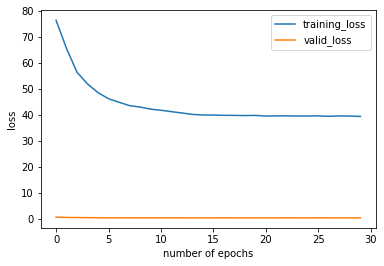

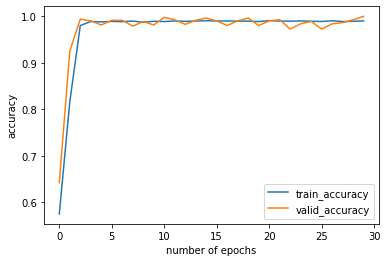

In [243]:
## PLOT EVOLUTION OF PERFORMANCE

# Plotting Loss
plt.figure(1)
plt.plot(list_train_loss, label = 'training_loss')
plt.plot(list_valid_loss, label = 'valid_loss')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# Plotting Accuracy
plt.figure(2)
plt.plot(list_train_accuracy, label = 'train_accuracy')
plt.plot(list_valid_accuracy, label = 'valid_accuracy')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


### 2. Using images and the feature vector

In [245]:
# Building the dataset
dataframe = pedestrians_df
training_dataframe, validation_dataframe, num_training_samples, num_validation_samples = training_validation_dataframes(dataframe, training_split = 0.7)
image_rep = 'JAAD_pictures'
image_size = (64, 64)
prediction_length = 4
training_dataloader = dataloader(training_dataframe, image_rep, image_size, prediction_length)
validation_dataloader = dataloader(validation_dataframe, image_rep, image_size, prediction_length)

In [247]:
# Creating the model
net3 = NET(activation = nn.Sigmoid(), loss = nn.BCELoss(), image_size = (64, 64), num_features = 11, batch_size = 10)


# Training
options = dict()
options['num_epochs'] = 10
options['base_lr'] = 1e-3
options['weight_decay'] = 0.0
options['prediction_length'] = 4

list_train_loss, list_train_accuracy, list_valid_loss, list_valid_accuracy = train_model(net3, training_dataloader, validation_dataloader, batch_size = 10, num_training_samples = num_training_samples, loss_function = nn.BCELoss(), options = options)



Training model...
Epoch: 1, Training loss: 0.836956, Training accuracy: 66.111115, Validation loss: 0.988705, Validation accuracy: 40.000000
Epoch: 2, Training loss: 0.841330, Training accuracy: 65.555550, Validation loss: 0.623403, Validation accuracy: 70.000000
Epoch: 3, Training loss: 0.898429, Training accuracy: 60.555553, Validation loss: 0.979335, Validation accuracy: 40.000000
Epoch: 4, Training loss: 0.842234, Training accuracy: 65.000000, Validation loss: 0.856215, Validation accuracy: 50.000000
Epoch: 5, Training loss: 0.835782, Training accuracy: 65.277771, Validation loss: 0.851594, Validation accuracy: 50.000000
Epoch: 6, Training loss: 0.825943, Training accuracy: 65.833336, Validation loss: 0.960820, Validation accuracy: 40.000000
Epoch: 7, Training loss: 0.697087, Training accuracy: 76.944443, Validation loss: 1.067538, Validation accuracy: 30.000002
Epoch: 8, Training loss: 0.773568, Training accuracy: 70.000000, Validation loss: 0.617737, Validation accuracy: 70.00000

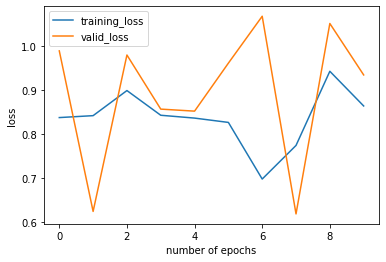

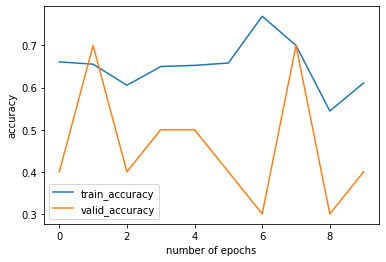

In [248]:
## PLOT EVOLUTION OF PERFORMANCE

# Plotting Loss
plt.figure(1)
plt.plot(list_train_loss, label = 'training_loss')
plt.plot(list_valid_loss, label = 'valid_loss')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# Plotting Accuracy
plt.figure(2)
plt.plot(list_train_accuracy, label = 'train_accuracy')
plt.plot(list_valid_accuracy, label = 'valid_accuracy')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#### The training time is so long that I cannot excess a batch size of 10, which is clearly not enough for a proper approximation of the gradient. to obtain meaningful results, I have no other choice but to do a preprocessing step where I extract all the frames from the videos and store them in different folders. The above results do not provide any meaningful information.

# III/SECOND METHOD: STORING FRAMES (OFFLINE IMAGE PROCESSING)

### 1. Extracting frames, storing them

In [168]:
import os
def store_images(dataframe, image_repository, image_size):
    """
    This function crops the images using the given bounding boxes, resizes them and saves them
    in their own folder.
    
    Needs 330 MB of storage space. 
    """
    num_trajec = len(dataframe.index)

    for id_trajec in range(num_trajec):
        print('Trajectory {} out of {}'.format(id_trajec, num_trajec))
        path_to_trajec = image_repository + '/' + str(id_trajec)
        if os.path.exists(path_to_trajec):
            return "error, folder already existing"
        
        os.makedirs(path_to_trajec)
        
        video_path = image_repository + '/' + dataframe.iloc[id_trajec]['video_id'] + '.mp4'
        frame_indices = dataframe.iloc[id_trajec]['frame_numbers']
        bounding_boxes = dataframe.iloc[id_trajec]['bounding_boxes']
        capture = cv2.VideoCapture(video_path)
        
        for index, bounding_box in zip(frame_indices, bounding_boxes):
            print('Image {} out of {}'.format(index, len(frame_indices)))
            capture.set(1, index)
            _, frame = capture.read()

            x, y, box_width, box_height = bounding_box
            x, y, box_width, box_height = int(x), int(y), int(box_width), int(box_height)
            image = frame[y:y + box_height, x:x + box_width]  # cropping
            img = cv2.resize(image, image_size, interpolation = cv2.INTER_NEAREST)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
            cv2.imwrite(path_to_trajec + '/' + str(index) + '.png', img)
            

In [ ]:
# Convert and store images (WARNING : TAKES 10 HOURS, FILLS YOUR REPOSITORY WITH 330 MB OF IMAGES)
dataframe = pedestrians_df
training_dataframe, validation_dataframe, num_training_samples, num_validation_samples = training_validation_dataframes(dataframe, training_split = 0.7)
image_rep = 'JAAD_pictures'
image_size = (64, 64)
prediction_length = 4
store_images(dataframe, image_rep, image_size)

### 2. Building the new dataloader

In [249]:
# Second dataloader: same as before except it uses the stored images
        
class dataloader2():
    def __init__(self, dataframe, image_repository, image_size, prediction_length):
        self.dataframe = dataframe
        self.image_repository = image_repository
        self.image_size = image_size
        self.prediction_length = prediction_length
        
    def generate_data(self):
        """
        This function generates one training sample : a group of trajectory_length images, 
        and the associated feature vector
        """
        num_trajec = len(self.dataframe.index)
        
        # pick a trajectory
        row_index = np.random.choice(self.dataframe.index)
        n_timesteps = len(self.dataframe.loc[row_index]['frame_numbers'])
        path_to_trajec = self.image_repository + '/' + str(row_index)

        # pick a sequence of prediction_lentgh images
        pred_start = prediction_length * np.random.randint(n_timesteps // self.prediction_length)
        pred_end = pred_start + self.prediction_length

        # retrieve images
        video_path = self.image_repository + '/' + self.dataframe.loc[row_index]['video_id'] + '.mp4'
        frame_indices = self.dataframe.loc[row_index]['frame_numbers'][pred_start:pred_end]
        image_list = np.zeros((self.prediction_length, self.image_size[0], self.image_size[1]))
        
        k=0
        for frame_index in frame_indices:
            frame = cv2.imread(path_to_trajec + '/' + str(frame_index) + '.png',cv2.IMREAD_GRAYSCALE)
            image_list[k] = frame
            k+=1
        

        # retrieve features
        features = ['moving slow', 'stopped', 'handwave', 'look', 'clear path', 
                    'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']
        num_features = len(features)
        feature_vector = np.zeros((self.prediction_length, num_features))
        
        k=0
        for feature in features:
            content = np.array(self.dataframe.loc[row_index][feature], dtype = 'int')[pred_start:pred_end]
            feature_vector[:,k] = content
            k+=1

        # retrieve labels
        labels = np.array(self.dataframe.loc[row_index]['crossing'], dtype = 'int')[pred_start:pred_end]
        labels = np.reshape(labels, (-1, 1))

        return (image_list, feature_vector, labels)
    
    
    def generate_feature_vec(self):
        """
        This function generates one training sample for the case where we only use the features as 
        training data and not the images.
        """
        num_trajec = len(self.dataframe.index)
        
        # pick a trajectory
        rrow_index = np.random.choice(self.dataframe.index)
        n_timesteps = len(self.dataframe.loc[row_index]['frame_numbers'])

        # pick a sequence of prediction_lentgh features
        pred_start = prediction_length * np.random.randint(n_timesteps // self.prediction_length)
        pred_end = pred_start + self.prediction_length
        
        # retrieve features
        features = ['moving slow', 'stopped', 'handwave', 'look', 'clear path', 
                    'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']
        num_features = len(features)
        feature_vector = np.zeros((self.prediction_length, num_features))
        
        k=0
        for feature in features:
            content = np.array(self.dataframe.loc[row_index][feature], dtype = 'int')[pred_start:pred_end]
            feature_vector[:,k] = content
            k+=1
        
        # retrieve labels
        labels = np.array(self.dataframe.loc[row_index]['crossing'], dtype = 'int')[pred_start:pred_end]
        labels = np.reshape(labels, (-1, 1))
        
        return feature_vector, labels
    
    
    def training_data(self, batch_size, just_feature_vector = False):
        """
        This function generates a batch of data, using the above functions.
        """
        
        feature_batch = np.zeros((batch_size, self.prediction_length, 11))
        label_batch = np.zeros((batch_size, self.prediction_length, 1))
        
        # If the images are not used
        if just_feature_vector:
            for i in range(batch_size):
                feature_vector, labels = self.generate_feature_vec()
                feature_batch[i] = feature_vector
                label_batch[i] = labels
            return (feature_batch, label_batch)
        
        # If the images are used
        else:
            image_batch = np.zeros((batch_size, self.prediction_length, self.image_size[0], self.image_size[1]))
            for i in range(batch_size):
                image_list, feature_vector, labels = self.generate_data()
    
                image_batch[i] = image_list
                feature_batch[i] = feature_vector
                label_batch[i] = labels

            return (image_batch, feature_batch, label_batch)
        
        

def training_validation_dataframes(dataframe, training_split = 0.7):
    """
    This function splits the main dataframe into two dataframes, one for training and one for validation.
    """
    new_dataframe = dataframe.copy()
    num_trajec = len(new_dataframe.index)
    train_idx = np.random.choice(num_trajec, int(training_split*num_trajec), replace = False)
    training_dataframe = new_dataframe.iloc[train_idx]
    validation_dataframe = new_dataframe.drop(train_idx)
    
    num_training_samples = 0
    for i, row in training_dataframe.iterrows():
        num_training_samples += len(row['frame_numbers'])//4
    num_validation_samples = 0
    for i, row in validation_dataframe.iterrows():
        num_validation_samples += len(row['frame_numbers'])//4
    
    return training_dataframe, validation_dataframe, num_training_samples, num_validation_samples





In [250]:
# Building the dataset
dataframe = pedestrians_df
training_dataframe, validation_dataframe, num_training_samples, num_validation_samples = training_validation_dataframes(dataframe, training_split = 0.7)
image_rep = 'JAAD_pictures'
image_size = (64, 64)
prediction_length = 4
training_dataloader = dataloader2(training_dataframe, image_rep, image_size, prediction_length)
validation_dataloader = dataloader2(validation_dataframe, image_rep, image_size, prediction_length)

### 3. Training the model

In [257]:
# Creating the model
net3 = NET(activation = nn.Sigmoid(), loss = nn.BCELoss(), image_size = (64, 64), num_features = 11, batch_size = 200)


# Training
options = dict()
options['num_epochs'] = 100
options['base_lr'] = 1e-3
options['weight_decay'] = 0.0
options['prediction_length'] = 4

list_train_loss, list_train_accuracy, list_valid_loss, list_valid_accuracy = train_model(net3, training_dataloader, validation_dataloader, batch_size = 200, num_training_samples = num_training_samples, loss_function = nn.BCELoss(), options = options)


Training model...
Epoch: 1, Training loss: 0.838642, Training accuracy: 62.069439, Validation loss: 0.702159, Validation accuracy: 61.000000
Epoch: 2, Training loss: 0.839782, Training accuracy: 61.583336, Validation loss: 0.704722, Validation accuracy: 60.500000
Epoch: 3, Training loss: 0.830753, Training accuracy: 62.166668, Validation loss: 0.730930, Validation accuracy: 57.500000
Epoch: 4, Training loss: 0.811757, Training accuracy: 63.791668, Validation loss: 0.673400, Validation accuracy: 63.375004
Epoch: 5, Training loss: 0.840943, Training accuracy: 60.333324, Validation loss: 0.677561, Validation accuracy: 62.750000
Epoch: 6, Training loss: 0.796445, Training accuracy: 64.847221, Validation loss: 0.710964, Validation accuracy: 58.875000
Epoch: 7, Training loss: 0.802682, Training accuracy: 63.875008, Validation loss: 0.695866, Validation accuracy: 60.375000
Epoch: 8, Training loss: 0.817387, Training accuracy: 61.930553, Validation loss: 0.676866, Validation accuracy: 62.37499

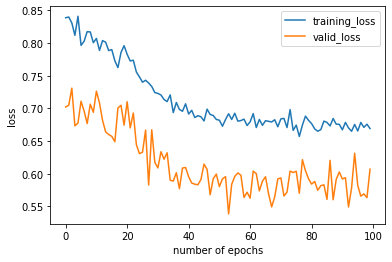

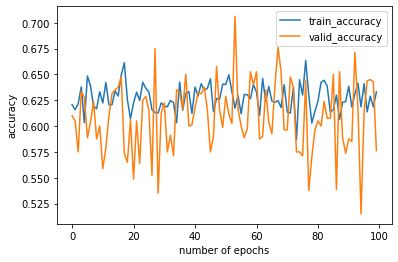

In [258]:
## PLOT EVOLUTION OF PERFORMANCE

# Plotting Loss
plt.figure(1)
plt.plot(list_train_loss, label = 'training_loss')
plt.plot(list_valid_loss, label = 'valid_loss')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# Plotting Accuracy
plt.figure(2)
plt.plot(list_train_accuracy, label = 'train_accuracy')
plt.plot(list_valid_accuracy, label = 'valid_accuracy')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Analysis

### 1. Model performances

#### 1. Models
Overall, I was not able to get meaningful feature extraction using the CNN network. I attribute this mostly to the complicate task of combining LSTMs and CNNs and the image processing step that resizes images and thus drops information. However, we can see clearly that the training and validation losses are going down, which is a good thing. Sadly, this gain does not seem enough for an improvement in accuracy.

The feature network performs well, and manages to achieve good training/validation accuracies (98%). This is mostly due to the fact that a lot of meaningful features are given, and the combination of features such as 'clear path', 'moving_slow' or 'stopping' gives a pretty good hunch on wether or not the pedestrian is crossing.

The combination of the two networks doesn't perform as well as the feature network alone, which is mainly due to the CNN-LSTM not being able to provide meaningful predictions. One could argue that adding the predictions from the CNN-LSTM with the predictions from the feature network is not the smartest way to combine the predictions of both networks.

#### 2. Weakness of my method
The main weakness of the method I used in this notebook is that it requires the use of groups of frames that constitute a trajectory. This means that you need to feed the network with a group of images corresponding to the same trajectory, and cannot just give one image alone. 

Due to the linear layers of the CNN-LSTM network, we use all the images of the given trajectory to predict the labels, meaning that for each image we use information of every other image to predict a label, which is the opposite of what was advocated in the beginning. To circumvent this, one could simply remove the linear layers and just change the last lstm layer to fit the shape (trajectory_length, 1), however, this technique gives worst results.

### 2. Ways to improve predictions

#### 1. Image processing
The first axis of improvement is the image processing step. I don't know how much of the information is lost when images are resized, nor do I know the most appropriate image size to use for the CNN.

#### 2. Class imbalance:'crossing' frames are outnumbered
It seems that the dataset is uneven regarding the number of 'crossing' and not crossing frames. Thus, I suspect the feature network to output '0' most of the time and get a good accuracy due to the high number of 'not crossing' frames in there. It would be judicious to put weights on the classes to remedy this issue

#### 3. Dimensionality reduction
One of the problem of the given dataset is that it presents a huge number of frames. Thus, it is likely that there is a redundancy in the data. This is a problem that often affects big datasets, and there are several ways to handle this 'diminishing returns' issue. One of the way to circumvent this issue is to train only on the most relevant datasamples. This can be achieved by selecting the samples that contribute the most to the gradient when doing the gradient descent step. See  [CRAIG](https://arxiv.org/pdf/1906.01827.pdf) for an example.

#### 4. Image segmentation
Another way to reduce the size of the datasets would be to perform segmentation on the input images to keep only the body of the pedestrians. Such task could be performed using a U-net trained for body segmentation. After predicting the masks for our input images, we would apply these masks to our input images and feed them to the CNN. This would probably help feature extraction

#### 5. Optimizing the trajectory length
For this study, I decided to use a fixed trajectory length of 4. However, a deeper study on the appropriate trajectory length would give us better results.

#### 6. Getting the position/velocity of the pedestrians in the space
If we had access to the position of the pedestrians in the image and their velocity (which could be computed using classical image processing techniques: optical flow...), we could probably achieve a better accuracy, since this information matters a lot in the prediction process. 

